In [1]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from collections import OrderedDict
import umap
from datetime import datetime, timedelta
from types import SimpleNamespace 
# Add parent path for import
import sys
sys.path.append("..")
from data.data_utils import *
from data.dataloader_detection import load_dataset_detection
from data.dataloader_classification import load_dataset_classification
import utils 
from model.model import NeuroGNN_Classification, DCRNNModel_classification
from constants import *
pd.set_option('display.max_columns', 50)
os.chdir(os.getcwd().split('NeuroGNN')[0] + 'NeuroGNN')
os.getcwd()
os.environ['$HDF5_USE_FILE_LOCKING'] = 'FALSE'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but

In [2]:
NEUROGNN_CLASSIFICATION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/neurognn/train/train-112'
NEUROGNN_CLASSIFICATION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/neurognn/train/train-109'
NEUROGNN_DETECTION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/neurognn/train/train-84'
NEUROGNN_DETECTION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/neurognn/train/train-82' 

DCRNN_DETECTION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/dcrnn/train/train-07'
DCRNN_DETECTION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/train/train-26'

DISTANCES_DF = pd.read_csv('./data/electrode_graph/distances_3d.csv')
DIST_ADJ, _, _ = utils.get_extended_adjacency_matrix(DISTANCES_DF, INCLUDED_CHANNELS, ELECTRODES_REGIONS)
INITIAL_SEM_EMBS = utils.get_semantic_embeds()

In [114]:
def evaluate(
        model,
        dataloader,
        args,
        save_dir,
        device,
        is_test=False,
        nll_meter=None,
        eval_set='dev',
        best_thresh=0.5):
    # To evaluate mode
    model.eval()

    # Define loss function
    if args.task == 'detection':
        loss_fn = nn.BCEWithLogitsLoss().to(device)
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)

    y_pred_all = []
    y_true_all = []
    y_prob_all = []
    file_name_all = []
    clips = []
    with torch.no_grad(), tqdm(total=len(dataloader.dataset)) as progress_bar:
        for x, y, seq_lengths, supports, _, file_name in dataloader:
            batch_size = x.shape[0]

            # Input seqs
            x = x.to(device)
            y = y.view(-1).to(device)  # (batch_size,)
            seq_lengths = seq_lengths.view(-1).to(device)  # (batch_size,)
            for i in range(len(supports)):
                supports[i] = supports[i].to(device)

            # Forward
            # (batch_size, num_classes)
            if args.model_name == "dcrnn":
                logits = model(x, seq_lengths, supports)
            elif args.model_name == "densecnn":
                x = x.transpose(-1, -2).reshape(batch_size, -1, args.num_nodes) # (batch_size, len*freq, num_nodes)
                logits = model(x)
            elif args.model_name == "lstm" or args.model_name == "cnnlstm":
                logits = model(x, seq_lengths)
            elif args.model_name == "neurognn":
                logits = model(x)
            else:
                raise NotImplementedError

            if args.num_classes == 1:  # binary detection
                logits = logits.view(-1)  # (batch_size,)
                y_prob = torch.sigmoid(logits).cpu().numpy()  # (batch_size, )
                y_true = y.cpu().numpy().astype(int)
                y_pred = (y_prob > best_thresh).astype(int)  # (batch_size, )
            else:
                # (batch_size, num_classes)
                y_prob = F.softmax(logits, dim=1).cpu().numpy()
                y_pred = np.argmax(y_prob, axis=1).reshape(-1)  # (batch_size,)
                y_true = y.cpu().numpy().astype(int)

            # Update loss
            loss = loss_fn(logits, y)
            if nll_meter is not None:
                nll_meter.update(loss.item(), batch_size)

            y_pred_all.append(y_pred)
            y_true_all.append(y_true)
            y_prob_all.append(y_prob)
            file_name_all.extend(file_name)
            clips.append(x.detach().cpu().numpy())
            
            # Log info
            progress_bar.update(batch_size)

    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_prob_all = np.concatenate(y_prob_all, axis=0)
    clips_all = np.concatenate(clips, axis=0)

    # Threshold search, for detection only
    if (args.task == "detection") and (eval_set == 'dev') and is_test:
        best_thresh = utils.thresh_max_f1(y_true=y_true_all, y_prob=y_prob_all)
        # update dev set y_pred based on best_thresh
        y_pred_all = (y_prob_all > best_thresh).astype(int)  # (batch_size, )
    else:
        best_thresh = best_thresh

    scores_dict, _, _ = utils.eval_dict(y_pred=y_pred_all,
                                        y=y_true_all,
                                        y_prob=y_prob_all,
                                        file_names=file_name_all,
                                        average="binary" if args.task == "detection" else "weighted")

    eval_loss = nll_meter.avg if (nll_meter is not None) else loss.item()
    results_list = [('loss', eval_loss),
                    ('acc', scores_dict['acc']),
                    ('F1', scores_dict['F1']),
                    ('recall', scores_dict['recall']),
                    ('precision', scores_dict['precision']),
                    ('best_thresh', best_thresh)]
    if 'auroc' in scores_dict.keys():
        results_list.append(('auroc', scores_dict['auroc']))
    results = OrderedDict(results_list)

    return results, y_pred_all, y_true_all, y_prob_all, clips_all, file_name_all


def eval_model(model, dataloader, args, is_test=True, nll_meter=None, eval_set='test', best_thresh=0.5):
    return evaluate(model, dataloader, args, args.save_dir, args.device, is_test=is_test,
             nll_meter=nll_meter, eval_set=eval_set, best_thresh=best_thresh)


def load_NeuroGNN_Classification(path, dist_adj=DIST_ADJ, initial_sem_embs=INITIAL_SEM_EMBS):
    args = SimpleNamespace(**json.load(open(f'{path}/args.json')))
    model = NeuroGNN_Classification(args, args.num_classes, args.device, 
                                        dist_adj, initial_sem_embs, 
                                        meta_node_indices=META_NODE_INDICES)
    model = utils.load_model_checkpoint(path+'/best.pth.tar', model)
    model.to(args.device)
    return model, args


def load_DCRNN_Classification(path):
    args = SimpleNamespace(**json.load(open(f'{path}/args.json')))
    model = DCRNNModel_classification(
            args=args, num_classes=args.num_classes, device=args.device)
    model = utils.load_model_checkpoint(path+'/best.pth.tar', model)
    model.to(args.device)
    return model, args


### Building the datasets and the modesl

In [4]:
# load args used to train saved models
classification_args = SimpleNamespace(**json.load(open(f'{NEUROGNN_CLASSIFICATION_PRETRAINED_PATH}/args.json')))
detection_args = SimpleNamespace(**json.load(open(f'{NEUROGNN_DETECTION_PRETRAINED_PATH}/args.json')))

print('building detection dataset...')
# load datasets
dataloaders_detection_neurognn, _, scaler_detection_neurognn = load_dataset_detection(
    input_dir=detection_args.input_dir,
    raw_data_dir=detection_args.raw_data_dir,
    train_batch_size=detection_args.train_batch_size,
    test_batch_size=detection_args.test_batch_size,
    time_step_size=detection_args.time_step_size,
    max_seq_len=detection_args.max_seq_len,
    standardize=True,
    num_workers=detection_args.num_workers,
    augmentation=detection_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=detection_args.graph_type,
    top_k=detection_args.top_k,
    filter_type=detection_args.filter_type,
    use_fft=detection_args.use_fft,
    sampling_ratio=1,
    seed=123,
    preproc_dir=detection_args.preproc_dir,
    augment_metaseries=True)

print('building classification dataset...')
dataloaders_classification_neurognn, _, scaler_classification_neurognn = load_dataset_classification(
    input_dir=classification_args.input_dir,
    raw_data_dir=classification_args.raw_data_dir,
    train_batch_size=classification_args.train_batch_size,
    test_batch_size=classification_args.test_batch_size,
    time_step_size=classification_args.time_step_size,
    max_seq_len=classification_args.max_seq_len,
    standardize=True,
    num_workers=classification_args.num_workers,
    padding_val=0.,
    augmentation=classification_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=classification_args.graph_type,
    top_k=classification_args.top_k,
    filter_type=classification_args.filter_type,
    use_fft=classification_args.use_fft,
    preproc_dir=classification_args.preproc_dir,
    augment_metaseries=True)


dataloaders_detection_dcrnn, _, scaler_detection_dcrnn = load_dataset_detection(
    input_dir=detection_args.input_dir,
    raw_data_dir=detection_args.raw_data_dir,
    train_batch_size=detection_args.train_batch_size,
    test_batch_size=detection_args.test_batch_size,
    time_step_size=detection_args.time_step_size,
    max_seq_len=detection_args.max_seq_len,
    standardize=True,
    num_workers=detection_args.num_workers,
    augmentation=detection_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=detection_args.graph_type,
    top_k=detection_args.top_k,
    filter_type=detection_args.filter_type,
    use_fft=detection_args.use_fft,
    sampling_ratio=1,
    seed=123,
    preproc_dir=detection_args.preproc_dir,
    augment_metaseries=False)

dataloaders_classification_dcrnn, _, scaler_classification_dcrnn = load_dataset_classification(
    input_dir=classification_args.input_dir,
    raw_data_dir=classification_args.raw_data_dir,
    train_batch_size=classification_args.train_batch_size,
    test_batch_size=classification_args.test_batch_size,
    time_step_size=classification_args.time_step_size,
    max_seq_len=classification_args.max_seq_len,
    standardize=True,
    num_workers=classification_args.num_workers,
    padding_val=0.,
    augmentation=classification_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=classification_args.graph_type,
    top_k=classification_args.top_k,
    filter_type=classification_args.filter_type,
    use_fft=classification_args.use_fft,
    preproc_dir=classification_args.preproc_dir,
    augment_metaseries=False)

print('All done!')

building detection dataset...
number of seizure files:  3594
Number of clips in train: 7188
Number of clips in dev: 5503
Number of clips in test: 8848
building classification dataset...
number of seizure files:  3594
Number of clips in train: 7188
Number of clips in dev: 5503
Number of clips in test: 8848
All done!


### Model evaluations

#### Detection model

In [115]:
neurognn_det_pretrained, neurognn_det_pretrained_args = load_NeuroGNN_Classification(NEUROGNN_DETECTION_PRETRAINED_PATH)
neurognn_det_nopretrained, neurognn_det_nopretrained_args = load_NeuroGNN_Classification(NEUROGNN_DETECTION_NOPRETRAINED_PATH)
dcrnn_det_pretrained, dcrnn_det_pretrained_args = load_DCRNN_Classification(DCRNN_DETECTION_PRETRAINED_PATH)
dcrnn_det_nopretrained, dcrnn_det_nopretrained_args = load_DCRNN_Classification(DCRNN_DETECTION_NOPRETRAINED_PATH)


neurognn_det_pretrained_test_results, neurognn_det_pretrained_test_preds, neurognn_det_pretrained_test_labels, neurognn_det_pretrained_test_probs, \
    neurognn_det_pretrained_clips, _ = eval_model(neurognn_det_pretrained,
                                                    dataloaders_detection_neurognn['test'],
                                                    neurognn_det_pretrained_args,
                                                    best_thresh=0.7512)

neurognn_det_nopretrained_test_results, neurognn_det_nopretrained_test_preds, neurognn_det_nopretrained_test_labels, \
    neurognn_det_nopretrained_test_probs, neurognn_det_nopretrained_clips, _ = eval_model(neurognn_det_nopretrained,
                                                    dataloaders_detection_neurognn['test'],
                                                    neurognn_det_nopretrained_args,
                                                    best_thresh=0.6259)
dcrnn_det_pretrained_test_results, dcrnn_det_pretrained_test_preds, dcrnn_det_pretrained_test_labels, dcrnn_det_pretrained_test_probs, \
    dcrnn_det_pretrained_clips, _ = eval_model(dcrnn_det_pretrained,
                                                    dataloaders_detection_dcrnn['test'],
                                                    dcrnn_det_pretrained_args,
                                                    best_thresh=0.8196)
dcrnn_det_nopretrained_test_results, dcrnn_det_nopretrained_test_preds, dcrnn_det_nopretrained_test_labels, \
    dcrnn_det_nopretrained_test_probs, dcrnn_det_nopretrained_clips, _ = eval_model(dcrnn_det_nopretrained,
                                                    dataloaders_detection_dcrnn['test'],
                                                    dcrnn_det_nopretrained_args,
                                                    best_thresh=0.8491)


100%|██████████| 8848/8848 [00:13<00:00, 659.35it/s]


In [20]:
def viz_confusion_mat(test_labels, test_preds, save_path=None, title='Seizure Detection Confusion Matrix'):
    for normalized in ['true', None]:
        conf_mat = confusion_matrix(test_labels, test_preds, normalize=normalized)
        # Visualize the confusion matrix
        class_names = ['Non-Seizure', 'Seizure']  # Replace with your class names
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
        # Display the confusion matrix plot
        plt.figure(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title, fontsize=16, fontweight='bold')
        # plt.show()
        if save_path:
            appendix = 'normalized' if normalized else 'unnormalized'
            plt.savefig(save_path[:-4]+appendix+'.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 800x600 with 0 Axes>

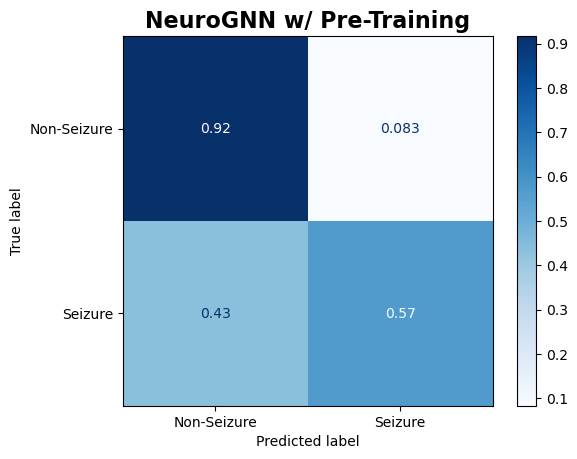

<Figure size 800x600 with 0 Axes>

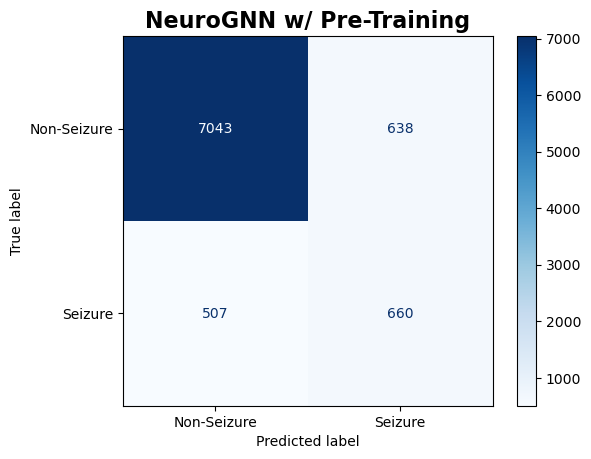

<Figure size 800x600 with 0 Axes>

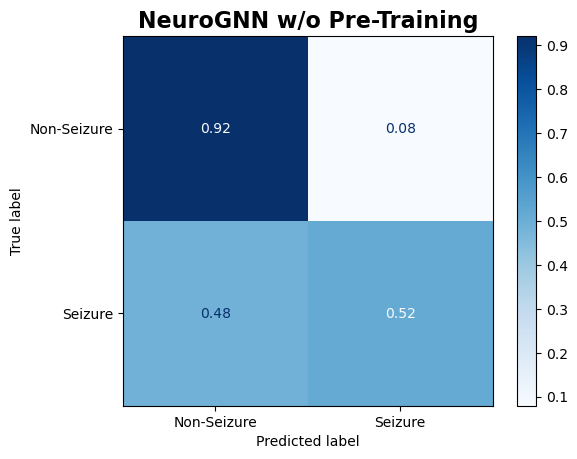

<Figure size 800x600 with 0 Axes>

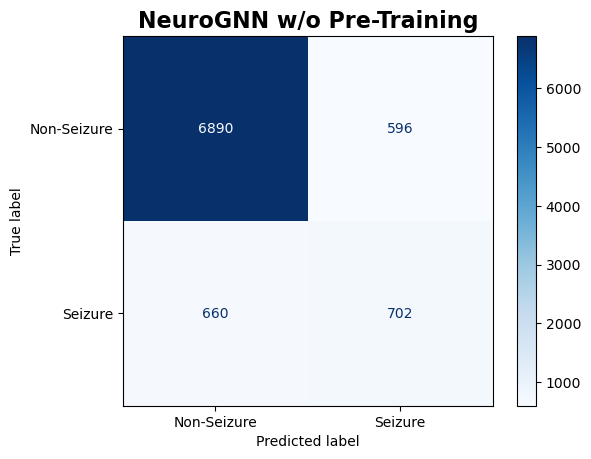

<Figure size 800x600 with 0 Axes>

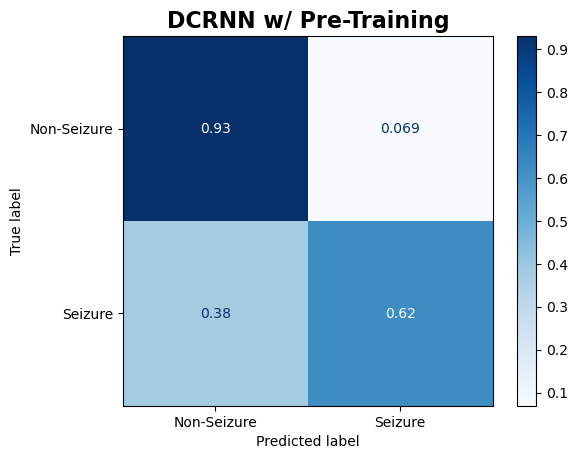

<Figure size 800x600 with 0 Axes>

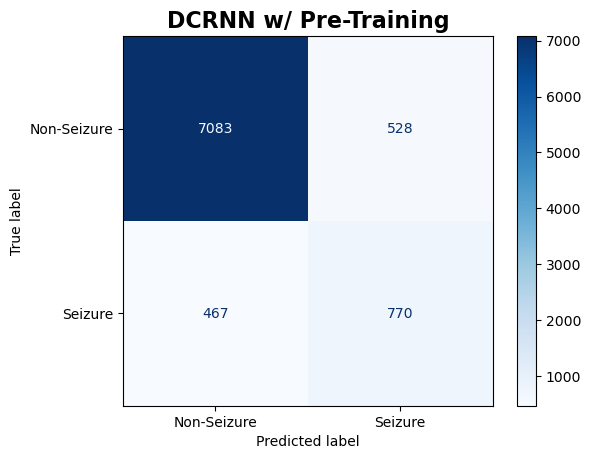

<Figure size 800x600 with 0 Axes>

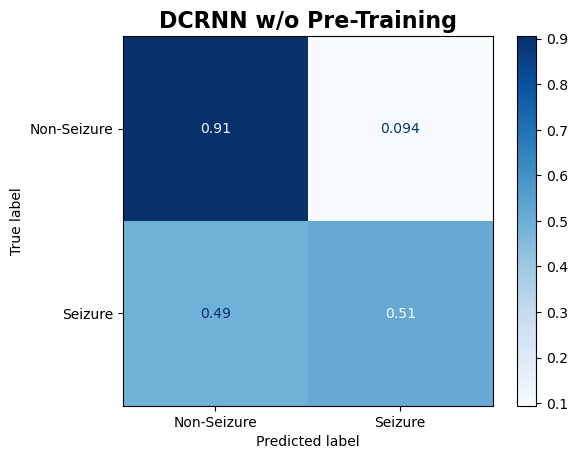

<Figure size 800x600 with 0 Axes>

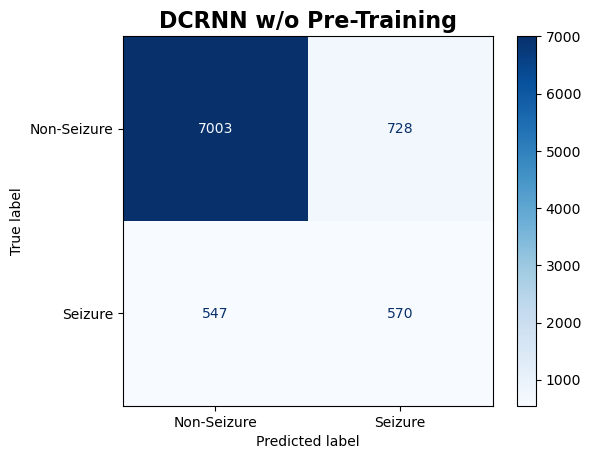

In [22]:
viz_confusion_mat(neurognn_det_pretrained_test_preds, neurognn_det_pretrained_test_labels, 'analysis/figures/detection/neurognn_det_pretrained_confusion_mat.png', title='NeuroGNN w/ Pre-Training')
viz_confusion_mat(neurognn_det_nopretrained_test_preds, neurognn_det_nopretrained_test_labels, 'analysis/figures/detection/neurognn_det_nopretrained_confusion_mat.png', title='NeuroGNN w/o Pre-Training')
viz_confusion_mat(dcrnn_det_pretrained_test_preds, dcrnn_det_pretrained_test_labels, 'analysis/figures/detection/dcrnn_det_pretrained_confusion_mat.png', title='DCRNN w/ Pre-Training')
viz_confusion_mat(dcrnn_det_nopretrained_test_preds, dcrnn_det_nopretrained_test_labels, 'analysis/figures/detection/dcrnn_det_nopretrained_confusion_mat.png', title='DCRNN w/o Pre-Training')

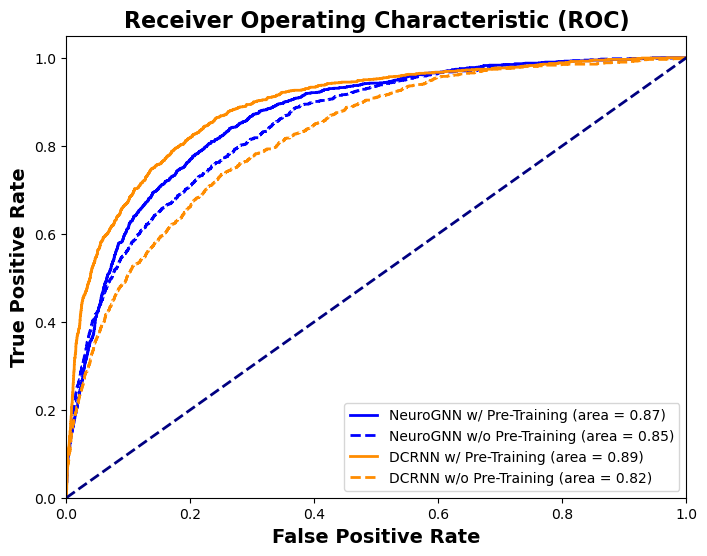

In [28]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
neurognn_pretrained_fpr, neurognn_pretrained_tpr, _ = roc_curve(neurognn_det_pretrained_test_labels, neurognn_det_pretrained_test_probs)
neurognn_nopretrained_fpr, neurognn_nopretrained_tpr, _ = roc_curve(neurognn_det_nopretrained_test_labels, neurognn_det_nopretrained_test_probs)
dcrnn_pretrained_fpr, dcrnn_pretrained_tpr, _ = roc_curve(dcrnn_det_pretrained_test_labels, dcrnn_det_pretrained_test_probs)
dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr, _ = roc_curve(dcrnn_det_nopretrained_test_labels, dcrnn_det_nopretrained_test_probs)

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
neurognn_pretrained_roc_auc = auc(neurognn_pretrained_fpr, neurognn_pretrained_tpr)
neurognn_nopretrained_roc_auc = auc(neurognn_nopretrained_fpr, neurognn_nopretrained_tpr)
dcrnn_pretrained_roc_auc = auc(dcrnn_pretrained_fpr, dcrnn_pretrained_tpr)
dcrnn_nopretrained_roc_auc = auc(dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(neurognn_pretrained_fpr, neurognn_pretrained_tpr, color='blue', lw=2, label='NeuroGNN w/ Pre-Training (area = %0.2f)' % neurognn_pretrained_roc_auc)
plt.plot(neurognn_nopretrained_fpr, neurognn_nopretrained_tpr, color='blue', linestyle='--', lw=2, label='NeuroGNN w/o Pre-Training (area = %0.2f)' % neurognn_nopretrained_roc_auc)
plt.plot(dcrnn_pretrained_fpr, dcrnn_pretrained_tpr, color='darkorange', lw=2, label='DCRNN w/ Pre-Training (area = %0.2f)' % dcrnn_pretrained_roc_auc)
plt.plot(dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr, linestyle='--', color='darkorange', lw=2, label='DCRNN w/o Pre-Training (area = %0.2f)' % dcrnn_nopretrained_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('analysis/figures/detection/auroc.png', dpi=300, bbox_inches='tight', transparent=True)

#### Classification Model

In [117]:
neurognn_classification_pretrained_model, neurognn_classification_pretrained_args = load_NeuroGNN_Classification(NEUROGNN_CLASSIFICATION_PRETRAINED_PATH)
neurognn_classification_nopretrained_model, neurognn_classification_nopretrained_args = load_NeuroGNN_Classification(NEUROGNN_CLASSIFICATION_NOPRETRAINED_PATH)

neurognn_classification_pretrained_test_results, neurognn_classification_pretrained_test_preds, \
    neurognn_classification_pretrained_test_labels, neurognn_classification_pretrained_test_probs, \
        neurognn_classification_pretrained_clips, neurognn_classificaiton_pretrained_files = eval_model(neurognn_classification_pretrained_model, 
                                                              dataloaders_classification_neurognn['test'],
                                                              neurognn_classification_pretrained_args,
                                                              )

neurognn_classification_nopretrained_test_results, neurognn_classification_nopretrained_test_preds, \
    neurognn_classification_nopretrained_test_labels, neurognn_classification_nopretrained_test_probs, \
        neurognn_classification_nopretrained_clips, neurognn_classification_nopretrained_files = eval_model(neurognn_classification_nopretrained_model,
                                                                dataloaders_classification_neurognn['test'],
                                                                neurognn_classification_nopretrained_args,
                                                                )

100%|██████████| 521/521 [00:02<00:00, 214.38it/s]


In [16]:

def viz_confusion_mat_classification(test_labels, test_preds, save_path=None, title='Seizure Classification Confusion Matrix'):
    for normalized in ['true', None]:
        conf_mat = confusion_matrix(test_labels, test_preds, normalize=normalized)
        # Visualize the confusion matrix
        class_names = ['CF', 'GN', 'AB', 'CT']  # Replace with your class names
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
        # Display the confusion matrix plot
        plt.figure(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title, fontsize=16, fontweight='bold')
        # rotate x-axis labels
        plt.xticks(rotation=45, fontsize=12)
        # plt.show()
        if save_path:
            appendix = 'normalized' if normalized else 'unnormalized'
            plt.savefig(save_path[:-4]+appendix+'.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 800x600 with 0 Axes>

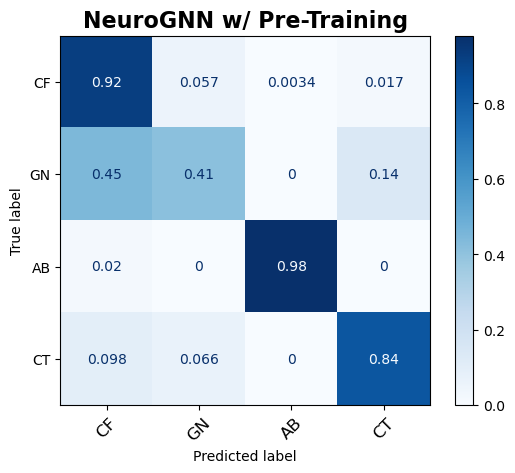

<Figure size 800x600 with 0 Axes>

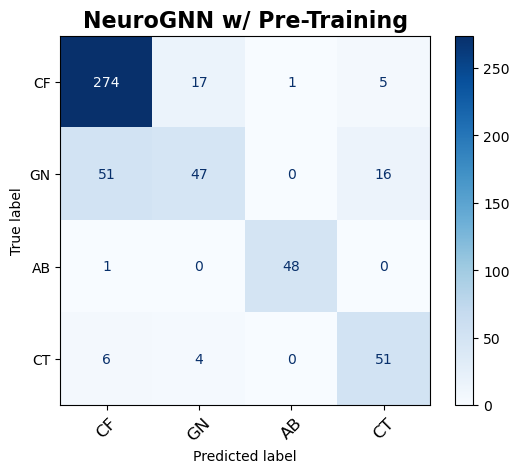

<Figure size 800x600 with 0 Axes>

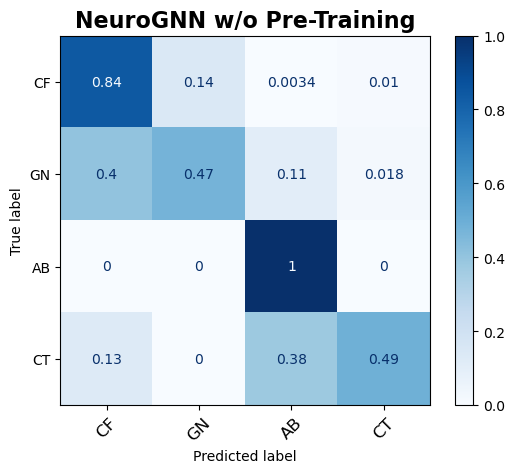

<Figure size 800x600 with 0 Axes>

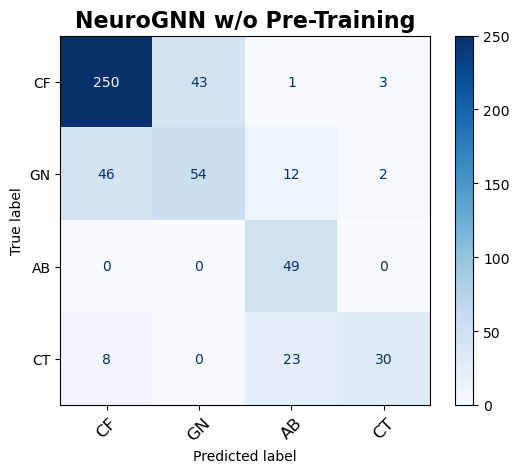

In [17]:
viz_confusion_mat_classification(neurognn_classification_pretrained_test_labels, neurognn_classification_pretrained_test_preds, title='NeuroGNN w/ Pre-Training', save_path='analysis/figures/classification/neurognn_pretrained_confusion_mat.png')
viz_confusion_mat_classification(neurognn_classification_nopretrained_test_labels, neurognn_classification_nopretrained_test_preds, title='NeuroGNN w/o Pre-Training', save_path='analysis/figures/classification/neurognn_nopretrained_confusion_mat.png')

## Interpretability

### Node embeddings during seizures

In [144]:
def get_seizure_sample(clips, labels, wanted_label, file_names=None):
    """
    Get a sample of seizure clips from the dataset.
    """
    seizure_clips = []
    target_files = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            seizure_clips.append(clips[i])
        if file_names:
            target_files.append(file_names[i])
    return torch.from_numpy(np.array(seizure_clips)), np.array(target_files)

def get_normal_sample(clips, labels, wanted_label=0):
    """
    Get a sample of normal clips from the dataset.
    """
    normal_clips = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            normal_clips.append(clips[i])
    return torch.from_numpy(np.array(normal_clips))

In [134]:
neurognn_cls_model = neurognn_classification_pretrained_model
neurognn_cls_model_args = neurognn_classification_pretrained_args
neurognn_cls_files = neurognn_classificaiton_pretrained_files
ab_clips, ab_files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 2, neurognn_cls_files)
ab_clips = ab_clips.to(neurognn_cls_model_args.device)
focal_clips, focal_files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 0, neurognn_cls_files)
focal_clips = focal_clips.to(neurognn_cls_model_args.device)

In [150]:
neurognn_det_model = neurognn_det_pretrained
neurognn_det_model_args = neurognn_det_pretrained_args
normal_clips = get_normal_sample(neurognn_det_pretrained_clips, neurognn_det_pretrained_test_labels)
normal_clips = normal_clips.to(neurognn_det_model_args.device)

In [135]:
neurognn_cls_model(ab_clips).softmax(dim=1).argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:0')

In [136]:
neurognn_cls_model.encoder(ab_clips)[0].shape ### YAY! Got the node embeddings!

torch.Size([49, 25, 256])

In [137]:
neurognn_cls_model(focal_clips[0:5]).softmax(dim=1).argmax(dim=1)

tensor([0, 0, 0, 1, 0], device='cuda:0')

In [153]:
print(neurognn_det_model(normal_clips[0:5]))

tensor([[ 0.1817],
        [-0.3920],
        [-3.1166],
        [-1.6694],
        [-0.2985]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [141]:
ab_files

array(['00009578_s011_t008.edf_0', '00008512_s007_t001.edf_0',
       '00009866_s003_t006.edf_6', '00008544_s006_t005.edf_0',
       '00008453_s007_t005.edf_0', '00010022_s003_t001.edf_1',
       '00008544_s005_t001.edf_0', '00009570_s001_t000.edf_1',
       '00000675_s002_t001.edf_3', '00002297_s003_t000.edf_0',
       '00009578_s005_t000.edf_0', '00001984_s001_t001.edf_1',
       '00010062_s008_t001.edf_1', '00001984_s001_t001.edf_2',
       '00009839_s005_t021.edf_0', '00005479_s004_t000.edf_0',
       '00008544_s002_t004.edf_0', '00008889_s004_t007.edf_2',
       '00010062_s004_t002.edf_1', '00008479_s002_t006.edf_0',
       '00009839_s005_t019.edf_0', '00010062_s006_t000.edf_0',
       '00008544_s004_t006.edf_0', '00000675_s002_t001.edf_12',
       '00000675_s002_t001.edf_1', '00009697_s003_t004.edf_0',
       '00008889_s004_t015.edf_1', '00000675_s001_t001.edf_2',
       '00009866_s003_t007.edf_0', '00009866_s003_t007.edf_5',
       '00008889_s004_t011.edf_0', '00009578_s029_t001

In [155]:
### During absence seizure, frontal lobe is more active, can our model find that?
node_embeddings_normal = neurognn_det_model.encoder(normal_clips)[0][0].detach().cpu().numpy()
node_embeddings_abs = neurognn_cls_model.encoder(ab_clips)[0][0].detach().cpu().numpy()
node_embeddings_focal = neurognn_cls_model.encoder(focal_clips)[0][0].detach().cpu().numpy()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.22 GiB (GPU 0; 23.65 GiB total capacity; 19.17 GiB already allocated; 2.45 GiB free; 20.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

[[0.99999994 0.97371197 0.9779254  0.9615766  0.9293916  0.9625276 ]
 [0.97371197 0.99999994 0.9910178  0.98051065 0.96833766 0.9948026 ]
 [0.9779254  0.9910178  0.9999998  0.98309743 0.97775304 0.9884393 ]
 [0.9615766  0.98051065 0.98309743 0.9999997  0.98353076 0.96311265]
 [0.9293916  0.96833766 0.97775304 0.98353076 1.         0.96079576]
 [0.9625276  0.9948026  0.9884393  0.96311265 0.96079576 1.0000001 ]]


<Axes: >

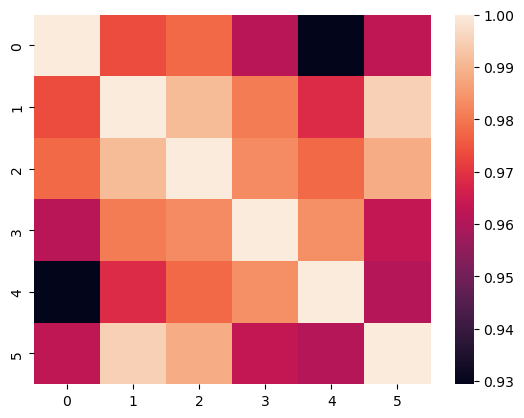

In [139]:
norms = np.linalg.norm(node_embeddings, axis=1, keepdims=True)
normalized_embeddings = node_embeddings / norms
cosine_scores = normalized_embeddings @ normalized_embeddings.T
print(cosine_scores[-6:, -6:])
sns.heatmap(cosine_scores[-6:, -6:])

In [129]:
def viz_embeddings(node_embeddings):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(node_embeddings)
    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])

    
    df_umap['node_label'] = pd.Series(INCLUDED_CHANNELS + CORTEX_REGIONS)
    node_regions = []
    for node_label in df_umap['node_label']:
        if node_label in ELECTRODES_REGIONS:
            node_regions.append(ELECTRODES_REGIONS[node_label])
        else:
            node_regions.append(node_label)
    df_umap['node_region'] = node_regions

    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', ax=ax, hue='node_region', s=100)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    # annotate node labels
    for i, label in enumerate(node_labels):
        ax.annotate(label, (embeddings_umap[i, 0], embeddings_umap[i, 1]), fontsize=8)

    plt.tight_layout()


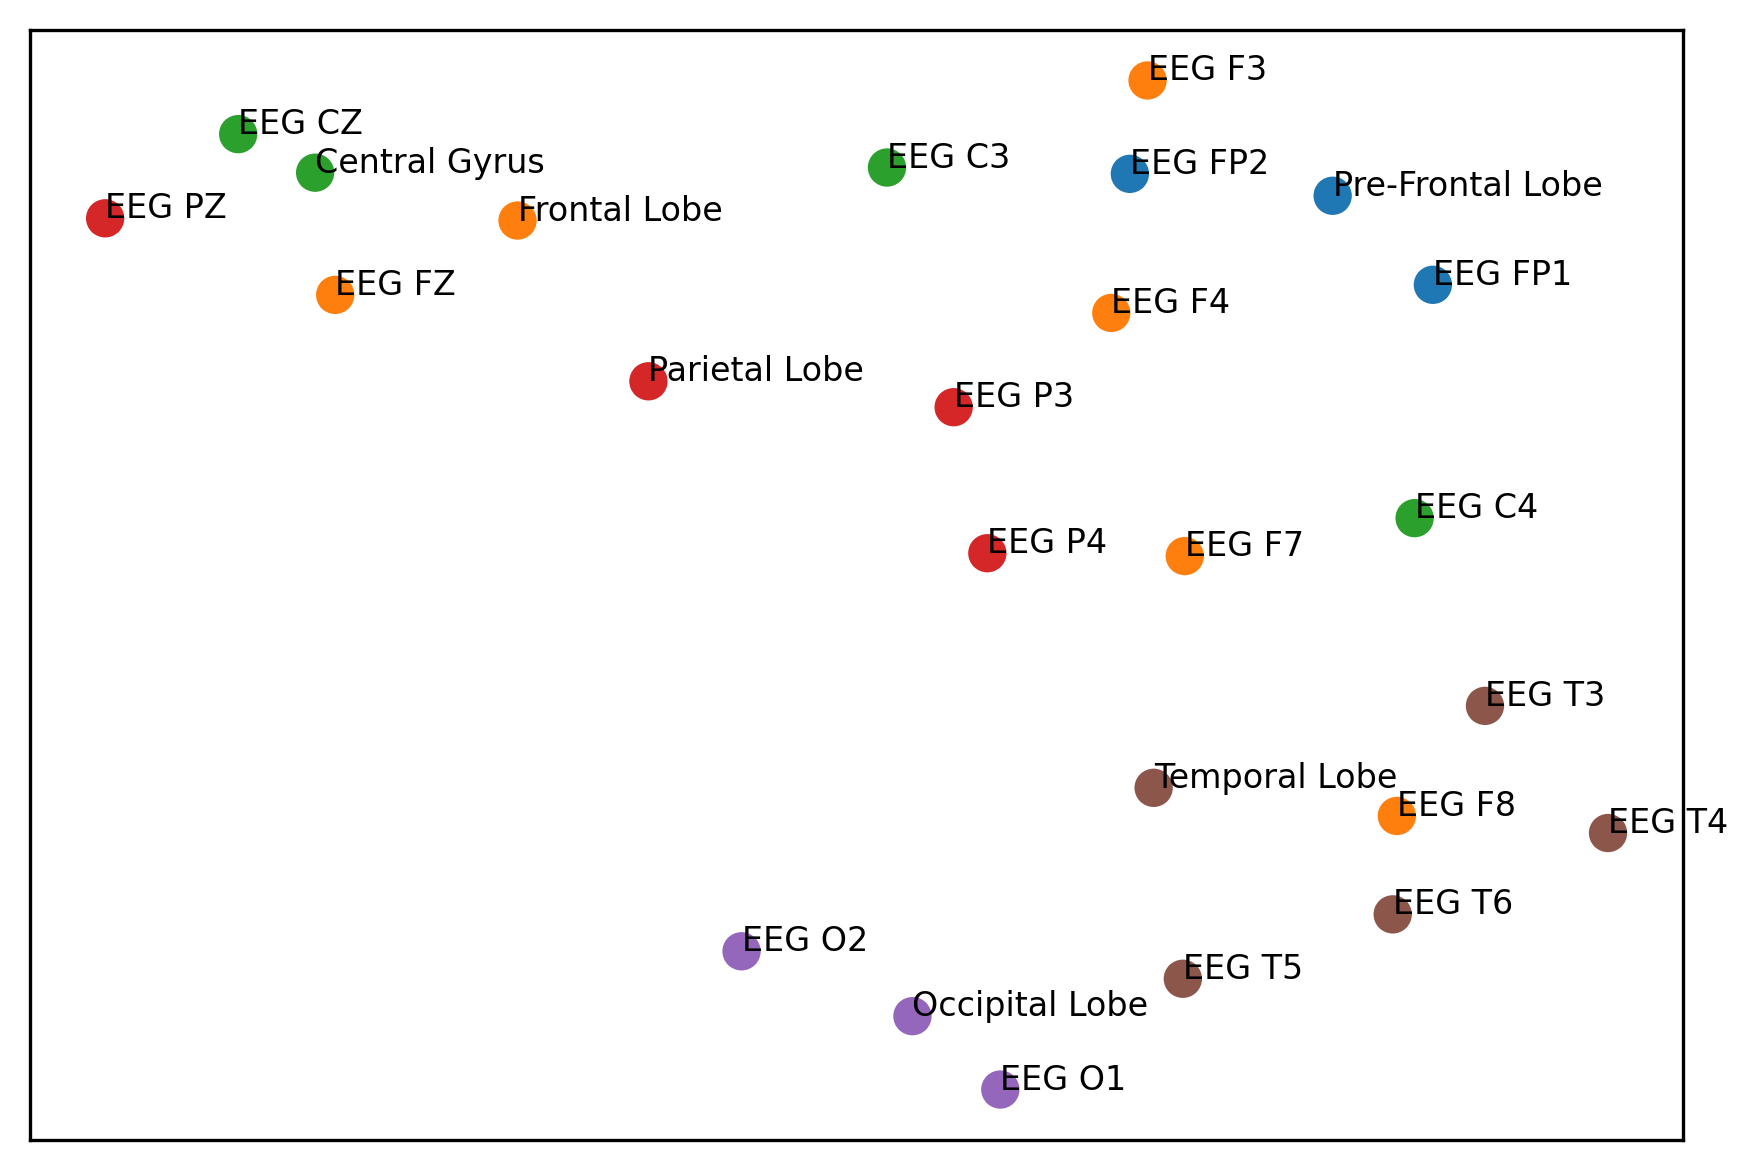

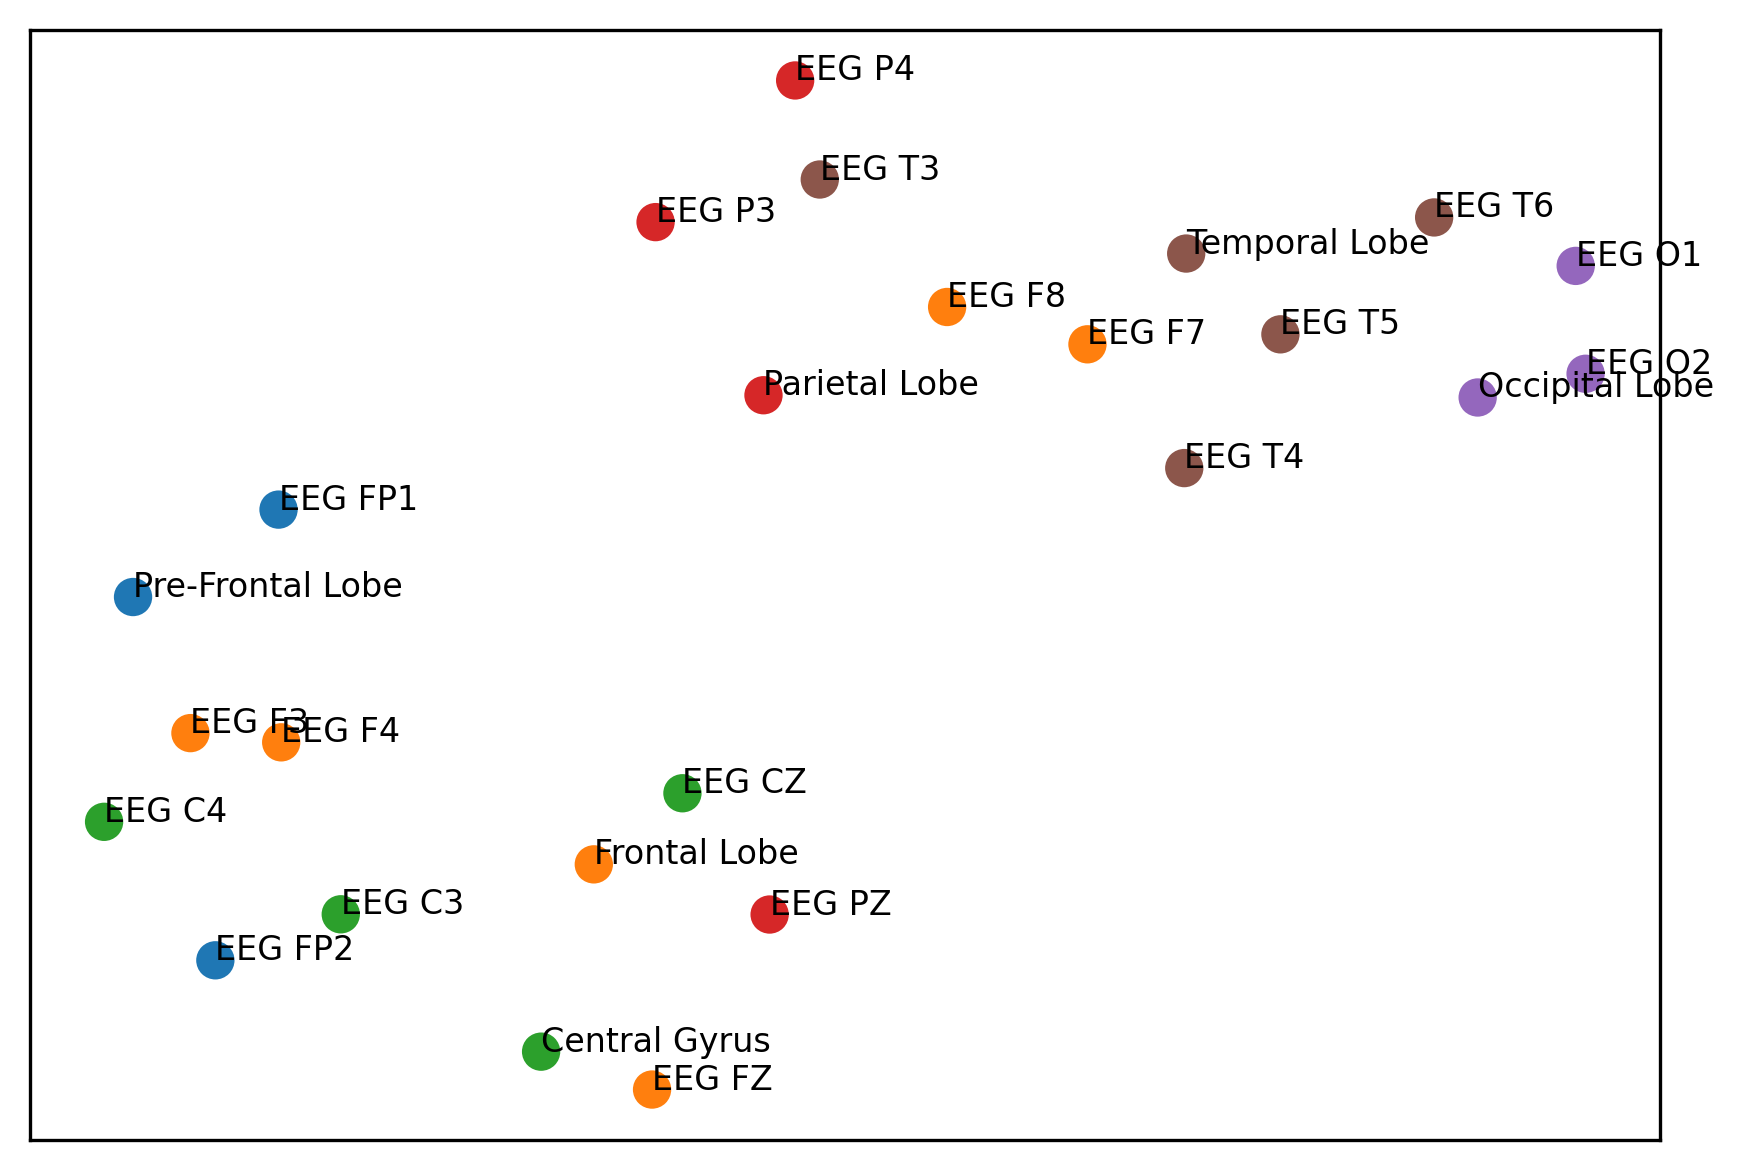

In [130]:
viz_embeddings(node_embeddings_abs)
viz_embeddings(node_embeddings_focal)